In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# 사람의 의견을 묻는 노드 설정
from typing import Annotated
from typing_extensions import TypedDict
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
# 중간에 사람에게 질문할지 여부를 묻는 상태 (ask_human) 을 추가한다
# 상태 설정
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

In [4]:
# LLM이 판단을 내려서 Human 도움이 필요하면
from pydantic import BaseModel

class HumanRequest(BaseModel):
    """Forward the conversation to an expert. Use when you can't assist directly or the user needs assistance that exceeds your authority.
    To use this function, pass the user's 'request' so that an expert can provide appropriate guidance.
    """

    request: str

In [6]:
from langchain_openai import ChatOpenAI
tool = TavilySearch(max_results=3)

tools = [tool, HumanRequest]

llm = ChatOpenAI(model='gpt-5-nano', temperature=0)

llm_with_tools = llm.bind_tools(tools)

def chatbot(state : State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False           # 사람에게 질문할지 여부 초기화

    # 도출 호출이 발생했고, HumanRequest 라는 이름의 클래스가 발동되었을때
    if response.tool_calls and response.tool_calls[0]["name"] == HumanRequest.__name__:
        ask_human = True        # 사람에게 질문

        return {"messages":[response], "ask_human":ask_human}

In [7]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [8]:
from langchain_core.messages import AIMessage, ToolMessage

# ToolMessage 생성을 위한 함수
def create_response(response: str, ai_message : AIMessage):
    return ToolMessage(content=response, tool_call_id = ai_message.tool_calls[0]["id"])

# 인간 노드
def human_node(state : State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        new_messages.append(create_response("No response from human.", state["messages"][-1]))

        return {
            "messages":new_messages,
            "ask_human":False
        }
    
graph_builder.add_node("human", human_node)

In [9]:
from langgraph.graph import END


# 다음 노드 선택
def select_next_node(state: State):
    # 인간에게 질문 여부 확인
    if state["ask_human"]:
        return "human"
    # 이전과 동일한 경로 설정
    return tools_condition(state)


# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

In [10]:
# 엣지 추가: 'tools'에서 'chatbot'으로
graph_builder.add_edge("tools", "chatbot")

# 엣지 추가: 'human'에서 'chatbot'으로
graph_builder.add_edge("human", "chatbot")

# 엣지 추가: START에서 'chatbot'으로
graph_builder.add_edge(START, "chatbot")

# 메모리 저장소 초기화
memory = MemorySaver()

# 그래프 컴파일: 메모리 체크포인터 사용
graph = graph_builder.compile(
    checkpointer=memory,
    # 'human' 이전에 인터럽트 설정
    interrupt_before=["human"],
)

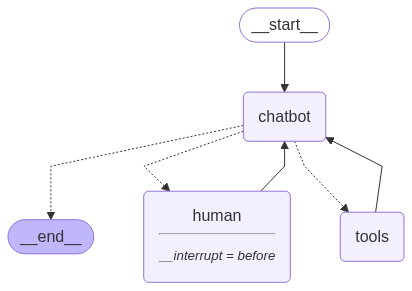

In [12]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
user_input = "이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?"

# config 설정
config = {"configurable": {"thread_id": "1"}}

# 스트림 또는 호출의 두 번째 위치 인수로서의 구성
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?


KeyError: 'ask_human'